In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from scipy import stats

%matplotlib inline
pd.set_option('display.max_columns', 100)

In [168]:
df = pd.read_csv('./loans_fs.csv', index_col=0)

/Users/timong/anaconda/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1. Predit willingess and ability of a borrower to repay us

2. Summarise the data and perform intial analysis on the focus that drive lending decisions (WHO SHOULD WE LEND MONEY TO?)

dti: a ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.

term: 36 months, 60 months, 600 months

payment_plan: y, n

grade: A, B, C, D, E, F, G

sub_grade: 1 to 5

emp_length: < 1 year to 10+ years increment by 1 year

home_ownership: rent, own, mortgage, other, none, any

verification_status: verified, source verified, not verified

loan_status: fully paid, does not meet credit policy. fully paid, current, in grace period, late (16-30 days), late (31-120 days), default, charged off, does not meet credit policy. charged off

purpose: credit card, car, small business, wedding, debt consolidation, home improvement, major purchase, medical, moving, vacation, house, renewable energy, educational, other

In [169]:
df.head(1)

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti
0,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65


In [170]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 887379 entries, 0 to 887378
Data columns (total 24 columns):
member_id              887379 non-null int64
loan_amnt              887379 non-null float64
funded_amnt            887379 non-null float64
funded_amnt_inv        887379 non-null float64
term                   887379 non-null object
int_rate               887379 non-null float64
installment            887379 non-null float64
grade                  887379 non-null object
sub_grade              887379 non-null object
emp_title              835917 non-null object
emp_length             842554 non-null object
home_ownership         887379 non-null object
annual_inc             887375 non-null float64
verification_status    887379 non-null object
issue_d                887379 non-null object
loan_status            887379 non-null object
pymnt_plan             887379 non-null object
url                    887379 non-null object
desc                   126028 non-null object
purpose   

In [172]:
# converting terms in int
df['term2'] = [int(i.split()[0]) for i in df.term]

# changing payment_plan to 1 (y) and 0 (n) and filling na with 999
df = (
    df
    .pipe(lambda x: x.assign(payment_plan = np.where(x.pymnt_plan=='y',1,0)))
    .drop(['term', 'pymnt_plan'], axis=1)
    .rename(columns={"term2": "term"})
    .fillna(999)
)

In [173]:
df.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,term,payment_plan
count,8.873790e+05,887379.000000,8.873790e+05,887379.000000,887379.000000,887379.000000,8.873790e+05,8.873790e+05,887379.000000,887379.000000
mean,3.500182e+07,15177.429402,1.890163e+04,14702.464383,13.243805,436.717127,8.237772e+04,-8.562732e+03,45.641459,0.000011
std,2.411335e+07,16084.862871,1.115294e+05,8442.106732,4.771725,244.186593,1.488760e+05,1.375036e+05,38.337477,0.003357
min,7.047300e+04,-50000.000000,-2.000000e+05,0.000000,1.000000,15.670000,-5.000000e+04,-2.500000e+06,36.000000,0.000000
25%,1.087713e+07,8000.000000,8.000000e+03,8000.000000,9.990000,260.705000,4.500000e+04,1.169000e+01,36.000000,0.000000
50%,3.709528e+07,13000.000000,1.290000e+04,13000.000000,12.990000,382.550000,6.400000e+04,1.752000e+01,36.000000,0.000000
75%,5.847135e+07,20000.000000,2.000000e+04,20000.000000,16.290000,572.600000,9.000000e+04,2.386000e+01,60.000000,0.000000
max,7.354484e+07,250000.000000,2.500000e+06,35000.000000,28.990000,1445.460000,9.500000e+06,9.999000e+03,600.000000,1.000000


In [221]:
# assumptions
# funded_amnt, loan_amnt, annual_inc, dti cannot be less than 0. multiply them by -1
df_edit = (
    df
    .pipe(lambda x: x.assign(funded_amnt_edit = np.where(x.funded_amnt<0, x.funded_amnt*-1, x.funded_amnt)))
    .pipe(lambda x: x.assign(loan_amnt_edit = np.where(x.loan_amnt<0, x.loan_amnt*-1, x.loan_amnt)))
    .pipe(lambda x: x.assign(annual_inc_edit = np.where(x.annual_inc<0, x.annual_inc*-1, x.annual_inc)))
    .pipe(lambda x: x.assign(dti_edit = np.where(x.dti<0, x.dti*-1, x.dti)))
    .drop(["funded_amnt", "loan_amnt", "annual_inc", "dti"], axis=1)
    .rename(columns={"funded_amnt_edit": "funded_amnt", "loan_amnt_edit": "loan_amnt", "annual_inc_edit": "annual_inc", "dti_edit": "dti"})
    [[
        'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 
        'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
        'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
        'loan_status', 'url', 'desc', 'purpose', 'title', 'zip_code',
        'addr_state', 'dti', 'term', 'payment_plan']]
)

In [222]:
# assumptions 
# funded_amnt or funded_amnt_inv cannot be more than loan_amnt
# funded_amnt_inv cannot be more than funded_amnt

# checking out how many rows will be removed
count = df_edit.query("funded_amnt_inv > loan_amnt or funded_amnt > loan_amnt or funded_amnt_inv > funded_amnt").shape[0]
print("erroneous rows: " + str(count))

print("number of rows in raw data: " + str(df_edit.shape[0]))

erroneous rows: 4991
number of rows in raw data: 887379


In [223]:
# since assumed erroneous rows is only approx ~0.5% of raw data, I will remove them
df_edit = df_edit.query("funded_amnt_inv <= loan_amnt and funded_amnt <= loan_amnt and funded_amnt_inv <= funded_amnt")

In [224]:
df_edit.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,term,payment_plan
count,8.823880e+05,882388.000000,882388.000000,882388.000000,882388.000000,882388.000000,8.823880e+05,8.823880e+05,882388.000000,882388.000000
mean,3.499902e+07,15446.178014,14955.470666,14693.755111,13.242777,436.472471,7.898817e+04,4.299142e+03,45.643554,0.000011
std,2.411495e+07,14319.637392,9769.882116,8436.780490,4.771752,244.024472,1.150225e+05,9.723190e+04,38.372779,0.003366
min,7.047300e+04,500.000000,500.000000,0.000000,1.000000,15.670000,0.000000e+00,0.000000e+00,36.000000,0.000000
25%,1.086971e+07,8000.000000,8000.000000,8000.000000,9.990000,260.550000,4.500000e+04,1.195000e+01,36.000000,0.000000
50%,3.708695e+07,13000.000000,13000.000000,13000.000000,12.990000,382.550000,6.450000e+04,1.772000e+01,36.000000,0.000000
75%,5.847158e+07,20000.000000,20000.000000,20000.000000,16.290000,571.870000,9.000000e+04,2.407000e+01,60.000000,0.000000
max,7.354484e+07,250000.000000,200000.000000,35000.000000,28.990000,1445.460000,9.500000e+06,2.500000e+06,600.000000,1.000000


In [225]:
# seems there are some erroneous entry in dti
# will use IQR to remove outliers
upper_limit = np.percentile(df_edit.dti, 75) + (stats.iqr(df_edit.dti) * 1.5)
lower_limit = np.percentile(df_edit.dti, 25) - (stats.iqr(df_edit.dti) * 1.5)

df_edit2 = df_edit.query("dti >= {lower} and dti <= {upper}".format(lower=lower_limit, upper=upper_limit))

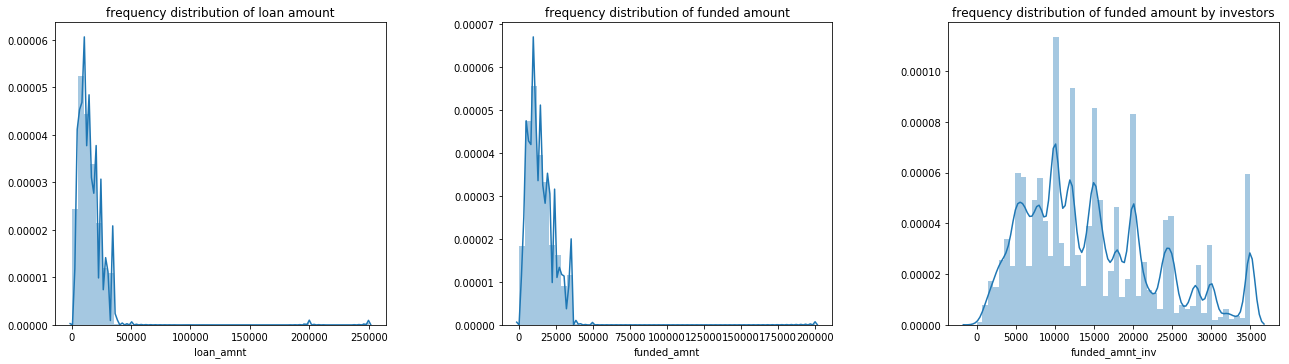

In [231]:
_ = plt.figure(figsize=(20,5))
_ = plt.subplot(131)
_ = sns.distplot(df_edit.loan_amnt)
_ = plt.title('frequency distribution of loan amount')

_ = plt.subplot(132)
_ = sns.distplot(df_edit.funded_amnt)
_ = plt.title('frequency distribution of funded amount')

_ = plt.subplot(133)
_ = sns.distplot(df_edit.funded_amnt_inv)
_ = plt.title('frequency distribution of funded amount by investors')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)